In [1]:
import albumentations
import functools
import json
import numpy as np
import os
import random
import tokenizers
import torch
import wandb

from glob import glob
from pathlib import Path
from PIL import Image, ImageDraw
from torchmetrics.detection import MeanAveragePrecision
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    EvalPrediction,
    Trainer,
    TrainingArguments
)
from types import SimpleNamespace
from typing import Dict, List, Tuple

import params

/Users/matthewzak/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/matthewzak/miniconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/matthewzak/miniconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <1FAC2D7E-618C-3A6D-BC20-D8F31AE257E9> /Users/matthewzak/miniconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/matthewzak/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.rea

In [2]:
DATASET_FOLDER = "training_dataset"
TRAIN_DATA = "train_data.json"
VAL_DATA = "val_data.json"
IMAGE_SIZE = 800
SEED = 42

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
set_seed(SEED)

In [5]:
def download_data():
    """Download the training & validation datatsets"""

    dataset_artifact = wandb.use_artifact(f'{params.FINAL_DATA_AT}:latest')
    dataset_path = Path(dataset_artifact.download())
    return dataset_path

In [6]:
def process_data(data: dict, data_path: str):
    """Convert data format

    Convert data format from json with multiple keys to a list of [image_info, image annotations]
    :param data: input data
    :type data: json
    :param data_path: path to images
    :type data_path: str
    :return: converted data into a list
    :rtype: [dict, [dict]]
    """

    processed_data = []
    for image_data in tqdm(data["images"]):
        image_path = os.path.join(data_path, image_data["file_name"])
        if not os.path.isfile(image_path):
            continue
        
        height = image_data["height"]
        width = image_data["width"]
        curr_image_id = image_data["id"]
        curr_annos = []
        for anno in data["annotations"]:
            if anno["image_id"] != curr_image_id:
                continue
            
            x, y, w, h = anno["bbox"]
            if w == 0 or h == 0:
                continue
            if x < 0:
                x = 0
            if y < 0:
                y = 0
    
            if x >= width:
                continue
            if x + w > width:
                w = width - x
            
            if y >= height:
                continue
            if y + h > height:
                h = height - y
            
            anno["bbox"] = [x, y, w, h]
            curr_annos.append(anno)

        if len(curr_annos) == 0:
            continue
    
        curr_image_data = image_data.copy()
        curr_image_data["image_path"] = image_path
        processed_data.append((curr_image_data, curr_annos))

    return processed_data

In [7]:
class SeaWorldDataset(Dataset):
    """
    """

    def __init__(self, data: List[Tuple[Dict, List[Dict]]], image_processor, is_augment: str = True):
        self._data = data
        self._image_processor = image_processor

        if is_augment:
            self._transform = albumentations.Compose(
                [
                    albumentations.ShiftScaleRotate(
                        shift_limit=(0, 0.3),
                        scale_limit=0.2,
                        rotate_limit=(-20, 20)
                    ),
                    albumentations.HorizontalFlip(p=.5),
                    albumentations.VerticalFlip(p=.5),
                    albumentations.RandomBrightnessContrast(p=.5),
                    albumentations.LongestMaxSize(image_processor.size["longest_edge"], always_apply=True),
                ],
                bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
            )
        else:
            self._transform = albumentations.Compose(
                [
                    albumentations.LongestMaxSize(image_processor.size["longest_edge"], always_apply=True),
                ],
                bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
            )

    def __len__(self):
        return len(self._data)

    @staticmethod
    def _format_processed_annotations(bboxes, categories, image_id):
        """
        """

        processed_annotations = []
        for bbox, category_id in zip(bboxes, categories):
            processed_annotations.append(
                {
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": [int(arg + 0.5) for arg in bbox],
                    "isCrowd": 0,
                    "area": int(bbox[2] * bbox[3] + 0.5)
                }
            )

        return processed_annotations

    def __getitem__(self, index) -> Tuple[np.ndarray, List[Dict], int]:
        """
        """

        image_data, annotations = self._data[index]
        image_id = image_data["id"]
        bboxes, categories = [], []
        for annotation in annotations:
            bbox = annotation["bbox"]
            category_id = annotation["category_id"]
            bboxes.append(bbox)
            categories.append(category_id)

        image = np.array(Image.open(image_data["image_path"]).convert("RGB"))
        out = self._transform(
            image=image,
            bboxes=bboxes,
            categories=categories
        )
        annotations = self._format_processed_annotations(
            out["bboxes"], out["categories"], image_id
        )

        processed_image = self._image_processor.preprocess(
            images=image, annotations={"image_id": image_id, "annotations": annotations}, return_tensors="pt"
        )
        for key, val in processed_image.items():
            processed_image[key] = val[0]

        return processed_image

In [8]:
def collate_fn(batch, is_yolo=False):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    if not is_yolo:
        batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [9]:
def get_training_params(label2id, id2label):
    checkpoint = "microsoft/conditional-detr-resnet-50"
    model = AutoModelForObjectDetection.from_pretrained(
            checkpoint,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
    )

    for param in model.model.parameters():
        param.requires_grad = False

    image_processor = AutoImageProcessor.from_pretrained(checkpoint)
    
    return model, image_processor

In [10]:
with open('data/train_data.json', 'r') as f:
    train_data = json.load(f)
with open('data/val_data.json', 'r') as f:
    val_data = json.load(f)
id2label = {cat["id"]: cat["name"] for cat in val_data["categories"]}
label2id = {name: cat_id for cat_id, name in id2label.items()}
val_data = process_data(val_data, "./data/images/")
train_data = process_data(train_data, "./data/images/")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4760/4760 [00:02<00:00, 2195.50it/s]


In [11]:
model, image_processor = get_training_params(label2id, id2label)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([133, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([133]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `

In [12]:
train_dataset = SeaWorldDataset(train_data, image_processor, is_augment=True)
val_dataset = SeaWorldDataset(val_data, image_processor, is_augment=False)

In [13]:
for pos, _ in tqdm(enumerate(val_dataset)):
    pass

1190it [01:05, 18.12it/s]


In [14]:
for pos_v, _ in tqdm(enumerate(val_dataset)):
    pass

1190it [01:03, 18.69it/s]


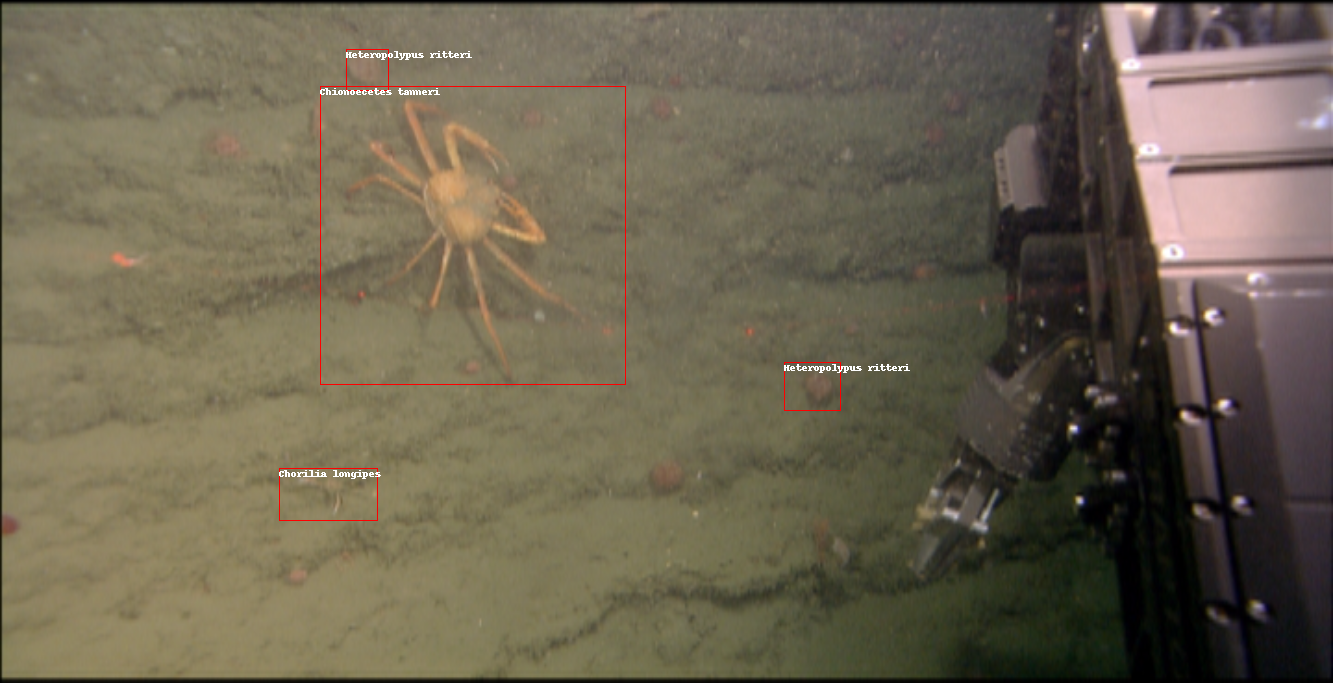

In [15]:
transform = albumentations.Compose(
    [
        albumentations.ShiftScaleRotate(
            shift_limit=(0, 0.3),
            scale_limit=0.2,
            rotate_limit=(-20, 20)
        ),
        albumentations.HorizontalFlip(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.RandomBrightnessContrast(p=.5),
        albumentations.LongestMaxSize(image_processor.size["longest_edge"], always_apply=True),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
)

image_data, annotations = train_dataset._data[155]
bboxes, categories = [], []
for annotation in annotations:
    bbox = annotation["bbox"]
    category_id = annotation["category_id"]
    bboxes.append(bbox)
    categories.append(category_id)

image = np.array(Image.open(image_data["image_path"]).convert("RGB"))
out = transform(
    image=image,
    bboxes=bboxes,
    categories=categories
)
image = Image.fromarray(out["image"])
bboxes = out["bboxes"]
categories = out["categories"]

draw = ImageDraw.Draw(image)

for box, cat in zip(bboxes, categories):
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[cat], fill="white")
image

In [21]:
def compute_metrics(eval_pred: EvalPrediction, map: MeanAveragePrecision):
    (scores, pred_boxes, last_hidden_state, encoder_last_hidden_state), labels = eval_pred
    # scores shape: (batch_size, number of detected anchors, num_classes + 1) last class is the no-object class
    # pred_boxes shape: (batch_size, number of detected anchors, 4)
    # https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/detr-resnet50/README.md
    predictions = []
    for score, box in zip(scores, pred_boxes):
        # Extract the bounding boxes, labels, and scores from the model's output
        pred_scores = torch.from_numpy(score[:, :-1])  # Exclude the no-object class
        pred_boxes = torch.from_numpy(box)
        pred_labels = torch.argmax(pred_scores, dim=-1)

        # Get the scores corresponding to the predicted labels
        pred_scores_for_labels = torch.gather(pred_scores, 1, pred_labels.unsqueeze(-1)).squeeze(-1)
        predictions.append(
            {
                "boxes": pred_boxes,
                "scores": pred_scores_for_labels,
                "labels": pred_labels,
            }
        )
    target = [
        {
            "boxes": torch.from_numpy(labels[i]["boxes"]),
            "labels": torch.from_numpy(labels[i]["class_labels"]),
        }
        for i in range(len(labels))
    ]
    map.update(preds=predictions, target=target)
    results = map.compute()

    # Convert tensors to scalars/lists, MLFlow doesn't really like tensors
    #formatted_results = dict()
    #for metric_name, value in results.items():
    #    value = value.tolist() if isinstance(value, torch.Tensor) else value
    #    wandb.log({metric_name: value})
    #    formatted_results[metric_name] = value
    results = {k: v.tolist() if isinstance(v, torch.Tensor) else v for k, v in results.items()}
    return results

In [22]:
mAP = MeanAveragePrecision(box_format="xywh")
metrics = functools.partial(compute_metrics, map=mAP, image_processor=image_processor)

In [23]:
model_name = "CondDETR"
training_mode = "bbox_classifier"
run_name = f"{model_name}_{training_mode}_final_tuned"

In [19]:
training_args = TrainingArguments(
    output_dir=run_name,
    per_device_train_batch_size=8,
    num_train_epochs=50,
    logging_steps=10,
    learning_rate=1e-4,
    weight_decay=1e-4,
    save_total_limit=2,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    run_name=run_name,
)

In [20]:
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="training_final_model", config=training_args)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=lambda batch: collate_fn(batch, False),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics,
    tokenizer=image_processor,
)
trainer.train()
wandb.finish()

wandb: Currently logged in as: matt-zak. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,4.630700,4.480794
2,3.991000,3.844540
3,3.894400,3.757469


KeyboardInterrupt: 